In [1]:
''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import timeit
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import xesmf as xe
import glob
import datetime
import calendar
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
from esio import metrics


import dask
#dask.config.set(scheduler='threads')  # overwrite default with threaded scheduler
#from dask.distributed import Client


# General plotting settings
sns.set_style('ticks')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

In [2]:
# client = Client()
# client

In [3]:
E = ed.EsioData.load()
# Directories
runType='forecast'


In [4]:
# Plotting Info
runType = 'forecast'
variables = ['sic']
metrics_all = {'sic':['IFD']}
# Some models are terrible/have serious issues, so don't include in MME
MME_NO = ['hcmr']

In [5]:
# Target time range
valid_start = np.datetime64('2019-06-01')
valid_end = np.datetime64('2019-09-30')

In [6]:
# SIO Report Year_Month
cyear = '2019'
cmonth = 'June'
#cmonth = 'July'

r_yr_mon = cyear+'_'+cmonth
mon_2_int = {v: k for k,v in enumerate(calendar.month_name)}

month_cal=dict((v,k) for k,v in enumerate(calendar.month_abbr))
date_str = pd.to_datetime(datetime.datetime(int(cyear), month_cal[cmonth[0:3]], 1)).strftime('%Y-%m-%d')
itstr = date_str
itstr

'2019-06-01'

In [7]:
stero_grid_file = E.obs['NSIDC_0051']['grid']
obs_grid = import_data.load_grid_info(stero_grid_file, model='NSIDC')
# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)

In [20]:
cyear = '2019'
cmonth = 'June'
#cmonth = 'July'
#cmonth = 'August'

c_vmin = [x.timetuple().tm_yday for x in [pd.datetime(int(cyear),  month_cal[cmonth[0:3]]  ,1)]][0]
c_vmax = [x.timetuple().tm_yday for x in [pd.datetime(int(cyear),10,1)]][0]
print(c_vmin, c_vmax)

152 274


In [9]:
# Get dates for plot
last_IFD = pd.to_datetime((np.datetime64('2019-01-01') + np.timedelta64(int(c_vmax),'D')))

In [10]:
# Get monthly ticks
DOY_months = [x.timetuple().tm_yday for x in pd.date_range(date_str,'2019-10-30', freq='MS')]
DOY_labels = [calendar.month_abbr[mn]+' 1' for mn in np.arange( month_cal[cmonth[0:3]]  ,last_IFD.month+1)]
assert len(DOY_months)==len(DOY_labels)

In [11]:
# compute climo10yr IFD
# BE SURE THESE ARE NON OVERLAPPING, MUST BE UPDATED FOR NEW DATA
# Get bootstrap and nrt observations with pole hole already filled in
ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'_yearly/*.nc', concat_dim='time', autoclose=True, parallel=True).sic
ds_79 = xr.open_mfdataset(E.obs['NSIDC_0079']['sipn_nc']+'_yearly/*.nc', concat_dim='time', autoclose=True, parallel=True).sic

pred_year = int(cyear)
start_year = pred_year-10
start_year = pred_year-2


ds_79=ds_79.sel(time=slice(str(start_year),str(pred_year-1)))  # end year just has to be way in the future
ds_81=ds_81.sel(time=slice('2015',str(pred_year-1)))  # restrict to before prediciton year, lower year not important

# Combine bootstrap with NASA NRT
ds_81 = ds_79.combine_first(ds_81)  # takes ds_79 as priority
ds_79 = None

year_all = [x.year for x in pd.to_datetime(ds_81.time.values)]
ds_81.coords['year'] = xr.DataArray(year_all, dims='time', coords={'time':ds_81.time})
DOY = [x.timetuple().tm_yday for x in pd.to_datetime(ds_81.time.values)]
ds_81.coords['doy'] = xr.DataArray(DOY, dims='time', coords={'time':ds_81.time})
print(ds_81)  

<xarray.DataArray 'sic' (time: 1461, y: 448, x: 304)>
dask.array<shape=(1461, 448, 304), dtype=float64, chunksize=(365, 448, 304)>
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2018-12-31
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2015 2015 2015 2015 2015 ... 2018 2018 2018 2018 2018
    doy      (time) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365


In [23]:
# Calc observed Ice Free Day
da_IFD = ds_81.groupby('time.year').apply(metrics.calc_IFD)
da_IFD.name = 'IFD'
ObsYears=da_IFD.year.values

ifd_all=[]  # need to deal with years when never get below 0.15
            # choose to make them a high value that if all yrs are so high
            # it is masked out
            # but if say one yr is 270 and the rest are 275, then the mean is 274
            # which will be plotted but will be near the upper limit
for y in ObsYears:
    tmp=ds_81.sel(time=str(y)).min(dim='time') # min sic at anytime during year
    ifd = da_IFD.sel(year=y).where(tmp<0.15, other=c_vmax) # if never below 0.15 at anytime then set to max poss
    ifd_all.append(ifd)

ifd_all=xr.concat(ifd_all, dim='year')

climo=ifd_all.mean(dim='year')
climo = climo.where(tmp.notnull()) # Apply Orig mask 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


In [13]:
# Calc observed Ice Free Day
# NOT WORKING 
da_IFD2 = ds_81.groupby('time.year').apply(metrics.calc_IFD_10day, sic_threshold=0.5, Nday=10 )
da_IFD2.name = 'IFD'

ifd_all2=[]  # need to deal with years when never get below 0.15
            # choose to make them a high value that if all yrs are so high
            # it is masked out
            # but if say one yr is 270 and the rest are 275, then the mean is 274
            # which will be plotted but will be near the upper limit

for y in ObsYears:
    tmp=ds_81.sel(time=str(y)).min(dim='time') # min sic at anytime during year
    ifd = da_IFD2.sel(year=y).where(tmp<0.5, other=c_vmax) # if never below 0.15 at anytime then set to max poss
    ifd_all2.append(ifd)

ifd_all2=xr.concat(ifd_all2, dim='year')

climo2=ifd_all2.mean(dim='year')
climo2 = climo2.where(ds_81.isel(time=10).notnull()) # Apply Orig mask 


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


### THE CODE LOOKS LIKE

ds_ifd = metrics.calc_IFD_10day(ds_model, sic_threshold=0.5, DOY_s=DOY_first_vt[0], time_dim='fore_time', 
                                Nday=10, default_ice_free=pd.to_datetime('2019-06-01').timetuple().tm_yday)

Coordinates:
    lon         (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    lat         (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
  * fore_time   (fore_time) timedelta64[ns] 0 days 1 days ... 59 days 60 days
  * init_time   (init_time) datetime64[ns] 2019-08-01
    valid_time  (init_time, fore_time) datetime64[ns] 2019-08-01 ... 2019-09-30

In [58]:
ifd_all2=[]  # need to deal with years when never get below 0.15

for y in ObsYears:
    print('Operating on Year ',y)
    tmpo=ds_81.sel(time=str(y))
    
    first_day = np.datetime64(datetime.datetime(int(y),8,1))
    last_day = np.datetime64(datetime.datetime(int(y),10,1))
    print("Looking for times between",first_day,"and",last_day)

    tmpo = tmpo.sel(time=slice(first_day,last_day))
    
    tmp=tmpo.min(dim='time') # min sic at anytime during year
    
    DOY_first_vt = [x.timetuple().tm_yday for x in pd.to_datetime([tmpo.time.min().values])]
    print(DOY_first_vt[0])
    tmpo['time'] = tmpo.time - tmpo.time[0]
    print(tmpo)

    # setting the default_ice_free value equal to c_vmin is important
    ifd = metrics.calc_IFD_10day(tmpo, sic_threshold=0.5, DOY_s=DOY_first_vt[0], time_dim='time', 
                                    Nday=10, default_ice_free=pd.to_datetime(str(y)+'-08-01').timetuple().tm_yday)


    ifd_all2.append(ifd)

ifd_all2=xr.concat(ifd_all2, dim='year')

climo3 =ifd_all2.mean(dim='year')
climo3 = climo3.where(ds_81.isel(time=10).notnull()) # Apply Orig mask 



Operating on Year  2015
Looking for times between 2015-08-01T00:00:00.000000 and 2015-12-01T00:00:00.000000
213
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2015 2015 2015 2015 2015 ... 2015 2015 2015 2015 2015
    doy      (time) int64 213 214 215 216 217 218 ... 330 331 332 333 334 335


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2016
Looking for times between 2016-08-01T00:00:00.000000 and 2016-12-01T00:00:00.000000
214
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2016 2016 2016 2016 2016 ... 2016 2016 2016 2016 2016
    doy      (time) int64 214 215 216 217 218 219 ... 331 332 333 334 335 336


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2017
Looking for times between 2017-08-01T00:00:00.000000 and 2017-12-01T00:00:00.000000
213
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2017 2017 2017 2017 2017 ... 2017 2017 2017 2017 2017
    doy      (time) int64 213 214 215 216 217 218 ... 330 331 332 333 334 335


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2018
Looking for times between 2018-08-01T00:00:00.000000 and 2018-12-01T00:00:00.000000
213
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2018 2018 2018 2018 2018 ... 2018 2018 2018 2018 2018
    doy      (time) int64 213 214 215 216 217 218 ... 330 331 332 333 334 335


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


In [59]:
#cmap_std = matplotlib.colors.LinearSegmentedColormap.from_list('redhues', redhues, N=8)
cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
cmap_c.set_bad(color = 'lightgrey')


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


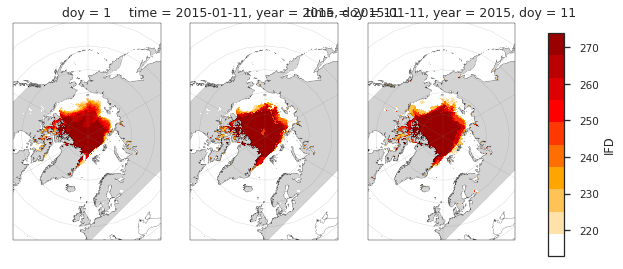

In [57]:
NPLOTS = 3
c_vmin=213
central_extent = [-3850000, 3725000, -5325000, 5850000] # (x0, x1, y0, y1

(f, axes) = ice_plot.multi_polar_axis(ncols=3, nrows=1, Nplots=NPLOTS, sizefcter=2, extent=central_extent, central_longitude=0)

i=0
p = climo.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)


i=1
p = climo3.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)



cbar_ax = f.add_axes([0.95, 0.07, .025, 0.775]) #  [left, bottom, width, height] w
c_label = 'IFD'
cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='vertical')

In [ ]:
    # Plot perenial ice as black
    #cper_mask = ds_IFD_All.sel(model=cmod)
    pb = cper_mask.where(cper_mask==275).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_b,
                          vmin=0, vmax=1)    
    
    add_subplot_title(cmod, custom_names, E, ax=axes[i])

    # Add init date
#    axes[i].annotate(pd.to_datetime(ds_IFD_All.sel(model=cmod).init_date.values).strftime('%m/%d'), xy=(.6, -.15), xycoords='axes fraction', )

# MME Mean
i = i + 1

cper_mask = ds_MME_avg.isel(init_time=0)

pmme = cper_mask.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c, vmin=c_vmin, vmax=c_vmax)

# Plot perenial ice as black
pb = cper_mask.where(cper_mask>=274).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False,
                      cmap=cmap_b,
                      vmin=0, vmax=1)    


axes[i].set_title('Multi-Forecast\nMean')


PlotObs = True
if PlotObs:       
    print('Climo 10 yr')
    # Climo10yrs
    i = i + 1

    pmme = climo.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                      transform=ccrs.PlateCarree(),
                                      add_colorbar=False, 
                                      cmap=cmap_c, vmin=c_vmin, vmax=c_vmax)

    # Plot perenial ice as black
    pb = climo.where(climo>=274).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_b,
                          vmin=0, vmax=1)    


    axes[i].set_title('Climatology\nLast 10 yrs')
    

# MME Standard deviation
i = i + 1

print('MME sigma')

fld = ds_MME_std.isel(init_time=0)
landmask = fld.notnull()
fld = fld.where(cper_mask>c_vmin,other=0)
fld = fld.where(landmask)

pstd = fld.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_std,vmin=ds_MME_std.min().values, vmax=ds_MME_std.max().values)
axes[i].set_title('σ of\nForecasts')



# Make pretty
f.subplots_adjust(bottom=0.05)

cbar1vertical = True
if cbar1vertical:
#    cbar_ax = f.add_axes([0.95, 0.36, .05, 0.5]) #  [left, bottom, width, height]   span just top rows
    cbar_ax = f.add_axes([0.95, 0.07, .025, 0.775]) #  [left, bottom, width, height] w
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='vertical')
else:
    cbar_ax = f.add_axes([0.25, 0.001, .5, 0.04]) #  [left, bottom, width, height] w
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
cbar.set_ticks(DOY_months)
cbar.set_ticklabels(DOY_labels)

#f.subplots_adjust(right=0.05)
#cbar_ax_2 = f.add_axes([0.925, 0.1, .025, .28]) #  [left, bottom, width, height] w   FAR RIGHT
#cbar_ax_2 = f.add_axes([0.75, 0.1, .025, .28]) #  [left, bottom, width, height] w
#cbar_ax_2 = f.add_axes([0.35, 0.07, .025, .20]) #  [left, bottom, width, height] w

#cbar_ax_2 = f.add_axes([0.76, 0.07, .025, .20]) #  [left, bottom, width, height] w
cbar_ax_2 = f.add_axes([0.53, 0.08, .025, .18]) #  [left, bottom, width, height] w

cbar2 = f.colorbar(pstd, cax=cbar_ax_2, label='days', orientation='vertical')
# cbar.set_ticks(DOY_months)
# cbar.set_ticklabels(DOY_labels)